In [ ]:
import anndata as ad
import matplotlib.pyplot as plt
import novaice
import pandas as pd
import numpy as np
import scanpy as sc
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split

In [ ]:
adata = ad.read_h5ad("./MCE_Bioactive_Compounds_HEK293T_10μM.h5ad")
adata

AnnData object with n_obs × n_vars = 40778 × 3407
    obs: 'unique_ID', 'experiment_no', 'sample_plate', 'sample_row', 'sample_column', 'cell_id', 'pert_itime', 'pert_idose', 'sample', 'treatment', 'Ranking', 'Catalog Number', 'Compound name', 'CAS Number', 'CID', 'CAS', 'smiles', 'sample_type', 'sample_streamlined'
    var: 'gene_name'
    uns: 'experiment_no_colors', 'log1p', 'neighbors', 'pca', 'pert_idose_colors', 'pert_itime_colors', 'sample_plate_colors', 'sample_type_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'foundation_embedding', 'morgan_fingerprint'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var["highly_variable"]]

In [ ]:
bulk = sc.get.aggregate(
    adata[adata.obs["sample_type"] == "DMSO"], by="sample_type", func="mean"
).to_df(layer="mean")
bulk

,A2M,A4GNT,ABCA1,ABCB1,ABCF1,ABCG1,ABHD6,ABL1,ABL2,ACAA1,...,YY1,ZAP70,ZHX3,ZNF131,ZNF274,ZNF281,ZNF318,ZNF451,ZW10,ZYX
DMSO,0.498963,0.032199,0.164277,2.044113,5.522611,0.789176,0.957246,4.504195,2.709859,6.513611,...,5.959182,0.214113,4.636518,3.133561,2.51908,1.14927,5.380405,6.842835,3.299589,3.003838


In [ ]:
N = adata.n_obs  # or whatever your dataset length is
indices = np.arange(N)

training_compounds, testing_compounds = train_test_split(
    adata.obs["treatment"].unique(), test_size=0.2, random_state=42, shuffle=True
)

adata_train = adata[adata.obs["treatment"].isin(training_compounds)].copy()
adata_test = adata[adata.obs["treatment"].isin(testing_compounds)].copy()

In [ ]:
novaice.tl.ChemPertMLPModel.setup_anndata(
    adata=adata_train, drug_embedding_key="foundation_embedding", layer=None
)
model = novaice.tl.ChemPertMLPModel(adata=adata_train)

INFO     Generating sequential column names                                                                        


In [ ]:
model.train(
    train_size=0.8,
    early_stopping=True,
    early_stopping_monitor="reconstruction_loss_validation",
)

/Users/lucas-diedrich/mamba/envs/hackathon/lib/python3.12/site-packages/scvi/train/_trainrunner.py:84: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/lucas-diedrich/mamba/envs/hackathon/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/lucas-diedrich/mamba/envs/hackathon/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improv

Training:   0%|          | 0/236 [00:00<?, ?it/s]

Monitored metric reconstruction_loss_validation did not improve in the last 45 records. Best score: 2987.813. Signaling Trainer to stop.


<Axes: xlabel='epoch'>

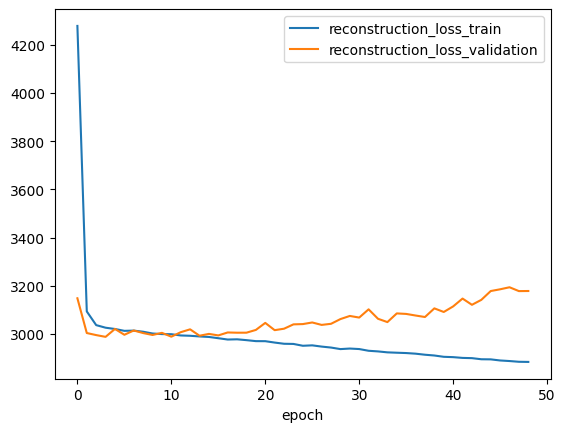

In [ ]:
fig, ax = plt.subplots(1, 1)
model.history["reconstruction_loss_train"].plot(ax=ax)
model.history["reconstruction_loss_validation"].plot(ax=ax)

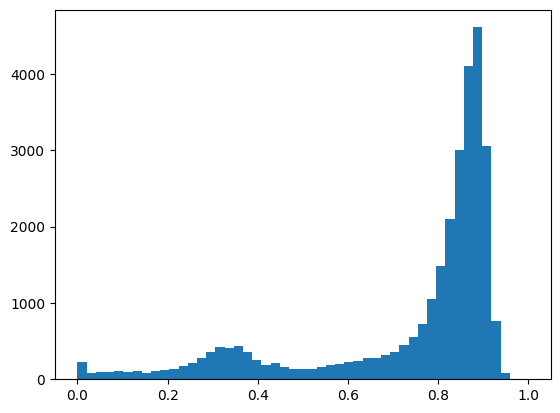

In [ ]:
r2 = model.get_prediction_error(method="r2")
plt.hist(r2, bins=np.linspace(0, 1, 50))
plt.show()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


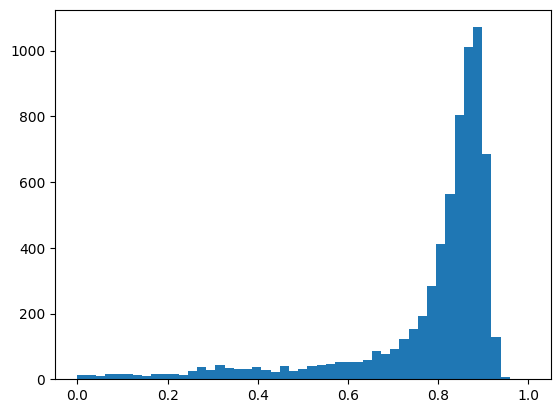

In [ ]:
r2_test = model.get_prediction_error(adata=adata_test, method="r2")
plt.hist(r2_test, bins=np.linspace(0, 1, 50))
plt.show()

In [ ]:
bulk = sc.get.aggregate(
    adata[adata.obs["sample_type"] == "DMSO"], by="sample_type", func="mean"
).to_df(layer="mean")

test = adata_test.to_df(layer=None).set_index(adata_test.obs["treatment"])

In [ ]:
bulk = sc.get.aggregate(
    adata[adata.obs["sample_type"] == "DMSO"], by="sample_type", func="mean"
).to_df(layer="mean")
bulk

,A2M,A4GNT,ABCA1,ABCB1,ABCF1,ABCG1,ABHD6,ABL1,ABL2,ACAA1,...,YY1,ZAP70,ZHX3,ZNF131,ZNF274,ZNF281,ZNF318,ZNF451,ZW10,ZYX
DMSO,0.498963,0.032199,0.164277,2.044113,5.522611,0.789176,0.957246,4.504195,2.709859,6.513611,...,5.959182,0.214113,4.636518,3.133561,2.51908,1.14927,5.380405,6.842835,3.299589,3.003838


In [ ]:
res = model.predict_gene_expression()
res

array([[ 5.7460892e-01,  4.6181165e-02,  1.9851778e-01, ...,
         7.1742754e+00,  3.5261116e+00,  3.3650885e+00],
       [ 5.8038998e-01, -1.7644407e-02,  2.9719558e-01, ...,
         7.4643831e+00,  4.0616708e+00,  3.7555335e+00],
       [ 5.5558062e-01,  1.9163501e-02,  1.9662765e-01, ...,
         7.1173582e+00,  3.6183865e+00,  3.4354770e+00],
       ...,
       [ 5.0342900e-01, -5.6482321e-03,  1.7884175e-01, ...,
         7.0498857e+00,  3.0496662e+00,  3.0012324e+00],
       [ 2.1222179e-01, -6.2276609e-03,  9.1129281e-02, ...,
         3.2268274e+00,  1.3613180e+00,  1.1637726e+00],
       [ 5.0660485e-01,  1.5103838e-02,  1.3697632e-01, ...,
         6.8969073e+00,  2.8716710e+00,  2.8287947e+00]],
      shape=(33959, 2000), dtype=float32)

In [ ]:
r2 = model.get_prediction_error(method="r2")

In [ ]:
adata.obs

,unique_ID,experiment_no,sample_plate,sample_row,sample_column,cell_id,pert_itime,pert_idose,sample,treatment,Ranking,Catalog Number,Compound name,CAS Number,CID,CAS,smiles,sample_type,sample_streamlined
0,MCE5_293T_24H_X1:D10,MCE_20220606,MCE5_293T_24H_X1,4,10,cell_293T,24 h,10.0 uM,HY_50946,HY_50946,6471.0,HY_50946,Imatinib (Mesylate),220127-57-1,3427.0,220127-57-1,CC(=CCCC(=CCCC(=CCSC1=NC=NN1)C)C)C,compound,HY_50946
1,MCE5_293T_24H_X1:G14,MCE_20220606,MCE5_293T_24H_X1,7,14,cell_293T,24 h,10.0 uM,HY_18686,HY_18686,11581.0,HY_18686,AS1949490,1203680-76-5,44473434.0,1203680-76-5,C[C@@H](C1=CC=CC=C1)NC(=O)C2=C(C=CS2)OCC3=CC=C...,compound,HY_18686
2,MCE5_293T_24H_X1:G22,MCE_20220606,MCE5_293T_24H_X1,7,22,cell_293T,24 h,10.0 uM,HY_17592A,HY_17592A,10898.0,HY_17592A,Bithionol (sulfoxide),844-26-8,68939.0,844-26-8,C1=C(C=C(C(=C1S(=O)C2=C(C(=CC(=C2)Cl)Cl)O)O)Cl)Cl,compound,HY_17592A
3,MCE5_293T_24H_X1:O22,MCE_20220606,MCE5_293T_24H_X1,15,22,cell_293T,24 h,10.0 uM,HY_19411,HY_19411,290.0,HY_19411,SSR180711 (hydrochloride),446031-79-4,9928899.0,446031-79-4,C1CN2CCC1N(CC2)C(=O)OC3=CC=C(C=C3)Br.Cl,compound,HY_19411
4,MCE5_293T_24H_X1:G08,MCE_20220606,MCE5_293T_24H_X1,7,8,cell_293T,24 h,10.0 uM,HY_18522,HY_18522,8793.0,HY_18522,AA26-9,1312782-34-5,46829239.0,1312782-34-5,C1CCN(C1)C(=O)N2C=CN=N2,compound,HY_18522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40773,MCE4_293T_24H_X3:P01,MCE_20221009_3,MCE4_293T_24H_X3,16,1,cell_293T,24 h,-666,Blank_42,Blank,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Blank,Blank
40774,MCE4_293T_24H_X3:L21,MCE_20221009_3,MCE4_293T_24H_X3,12,21,cell_293T,24 h,10.0 uM,HY_13954,HY_13954,12102.0,HY_13954,A 839977,870061-27-1,53325875.0,870061-27-1,C1=CC=C(C(=C1)CNC2=NN=NN2C3=C(C(=CC=C3)Cl)Cl)O...,compound,HY_13954
40775,MCE4_293T_24H_X3:P13,MCE_20221009_3,MCE4_293T_24H_X3,16,13,cell_293T,24 h,10.0 uM,HY_15414,HY_15414,11846.0,HY_15414,Vortioxetine,508233-74-7,9966051.0,508233-74-7,CC1=CC(=C(C=C1)SC2=CC=CC=C2N3CCNCC3)C,compound,HY_15414
40776,MCE4_293T_24H_X3:J23,MCE_20221009_3,MCE4_293T_24H_X3,10,23,cell_293T,24 h,-666,DMSO_02,DMSO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DMSO,DMSO


In [ ]:
predicted = pd.DataFrame(
    model.predict_gene_expression(adata_test),
    index=adata_test.obs["treatment"],
    columns=adata_test.var_names,
)
predicted_long = predicted.reset_index().melt(
    id_vars="treatment", var_name="genes", value_name="value"
)

predicted_long

,treatment,genes,value
0,HY_50946,A2M,0.474139
1,HY_19411,A2M,0.558629
2,HY_19928A,A2M,0.621627
3,HY_17471A,A2M,0.558838
4,HY_45409,A2M,0.572445
...,...,...,...
13637995,HY_16585,ZYX,2.567642
13637996,HY_15958,ZYX,2.871000
13637997,HY_13704,ZYX,2.969456
13637998,HY_131708A,ZYX,1.163773


In [ ]:
measured_long = (
    adata_test.to_df()
    .set_index(adata_test.obs["treatment"])
    .reset_index(names="treatment")
    .melt(id_vars="treatment", var_name="genes", value_name="value")
)

In [ ]:
measured_long

,treatment,genes,value
0,HY_50946,A2M,0.000000
1,HY_19411,A2M,0.000000
2,HY_19928A,A2M,0.000000
3,HY_17471A,A2M,0.000000
4,HY_45409,A2M,0.000000
...,...,...,...
13637995,HY_16585,ZYX,3.798407
13637996,HY_15958,ZYX,4.228685
13637997,HY_13704,ZYX,0.000000
13637998,HY_131708A,ZYX,3.955924


In [ ]:
res = pd.merge(
    predicted_long,
    measured_long,
    on=["treatment", "genes"],
    suffixes=("_predicted", "_measured"),
)
res

,treatment,genes,value_predicted,value_measured
0,HY_50946,A2M,0.474139,0.000000
1,HY_50946,A2M,0.474139,2.894532
2,HY_50946,A2M,0.474139,0.000000
3,HY_19411,A2M,0.558629,0.000000
4,HY_19411,A2M,0.558629,0.000000
...,...,...,...,...
40913995,HY_131708A,ZYX,1.163773,0.000000
40913996,HY_131708A,ZYX,1.163773,3.955924
40913997,HY_15414,ZYX,3.199958,3.898015
40913998,HY_15414,ZYX,3.199958,0.000000


[Text(0.5, 0, 'Value measured'), Text(0, 0.5, 'Value predicted')]

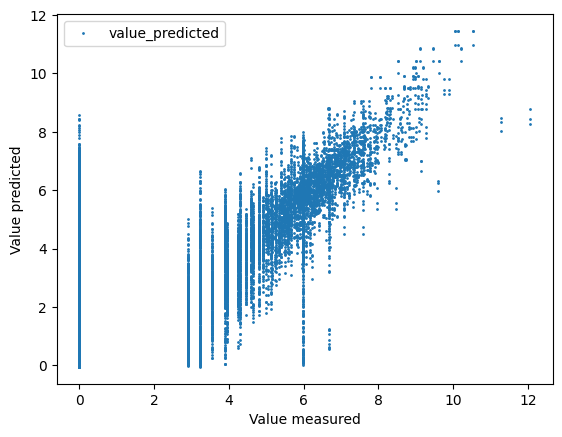

In [ ]:
res.loc[res["treatment"] == "HY_50946"].plot(
    "value_measured",
    "value_predicted",
    marker="o",
    linestyle="",
    markersize=1,
    label=None,
)
plt.gca().set(xlabel="Value measured", ylabel="Value predicted")

In [ ]:
import pandas as pd

In [ ]:
deg = pd.read_parquet(
    "/Users/lucas-diedrich/Documents/Programming/nucleate-hackathon/nucleate-hackathon-2025/preprocessing/dataset-1/read_data/MCE_Bioactive_Compounds_HEK293T_10μM.deg.parquet"
)
deg

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,Blank,TGFBI,0.315402,0.387819,7.524835e-01,7.535895e-01
1,Blank,CA4,0.000000,0.000000,1.000000e+00,1.000000e+00
2,Blank,PLA2G2A,0.000000,0.000000,1.000000e+00,1.000000e+00
3,Blank,SHH,0.000000,0.000000,1.000000e+00,1.000000e+00
4,Blank,ST8SIA6,0.000000,0.000000,1.000000e+00,1.000000e+00
...,...,...,...,...,...,...
38693294,HY_Z0816,PDK1,-32.811218,-32.265202,6.374044e-154,4.343273e-151
38693295,HY_Z0816,CD86,-32.823532,-32.308300,5.324195e-154,4.343273e-151
38693296,HY_Z0816,IGFBP5,-33.353111,-32.288464,2.337561e-157,2.654690e-154
38693297,HY_Z0816,XCL2,-34.503044,-32.386608,1.266685e-164,2.157798e-161


In [ ]:
# Get the test set as a DataFrame
test_df = adata_test.to_df()

# Get the bulk baseline as a 1D array (flatten the single row)
bulk_baseline = bulk.values.flatten()

# Compute correlation for each sample (row) in test set with the bulk baseline
# We'll use numpy's corrcoef or compute Pearson correlation


correlations = []
for idx in range(len(test_df)):
    # Get the expression values for this sample across all genes
    sample_expression = test_df.iloc[idx].values

    # Compute Pearson correlation with bulk baseline
    corr, _ = pearsonr(sample_expression, bulk_baseline)
    correlations.append(corr)

# Create a result dataframe
correlation_results = pd.DataFrame(
    {
        "treatment": adata_test.obs["treatment"].values,
        "correlation_with_bulk": correlations,
    }
)

print(f"Shape of test set: {test_df.shape}")
print(f"Shape of bulk baseline: {bulk_baseline.shape}")
print("\nCorrelation statistics:")
print(correlation_results["correlation_with_bulk"].describe())
print("\nFirst few results:")
correlation_results.head(10)

Shape of test set: (6819, 2000)
Shape of bulk baseline: (2000,)

Correlation statistics:
count    6819.000000
mean        0.893284
std         0.099133
min         0.071859
25%         0.892546
50%         0.931622
75%         0.944866
max         0.968535
Name: correlation_with_bulk, dtype: float64

First few results:


,treatment,correlation_with_bulk
0,HY_50946,0.866397
1,HY_19411,0.513023
2,HY_19928A,0.932219
3,HY_17471A,0.947005
4,HY_45409,0.932116
5,HY_19773,0.938517
6,HY_50172,0.936041
7,HY_19900,0.947448
8,HY_19946,0.929955
9,HY_17436,0.945636


In [ ]:
r2 = model.get_prediction_error(method="r2")
r2_test = model.get_prediction_error(adata=adata_test, method="r2")

In [ ]:
correlation_results

,treatment,correlation_with_bulk
0,HY_50946,0.866397
1,HY_19411,0.513023
2,HY_19928A,0.932219
3,HY_17471A,0.947005
4,HY_45409,0.932116
...,...,...
6814,HY_16585,0.882435
6815,HY_15958,0.933815
6816,HY_13704,0.717749
6817,HY_131708A,0.880738


(array([0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 4.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 3.000e+00, 4.000e+00, 4.000e+00, 8.000e+00, 1.300e+01,
        1.100e+01, 2.500e+01, 2.300e+01, 3.800e+01, 3.300e+01, 3.300e+01,
        4.800e+01, 3.300e+01, 4.200e+01, 4.400e+01, 6.300e+01, 7.800e+01,
        6.600e+01, 9.100e+01, 9.500e+01, 1.220e+02, 1.540e+02, 1.910e+02,
        2.290e+02, 3.420e+02, 6.610e+02, 1.775e+03, 2.366e+03, 1.970e+02,
        0.000e+00]),
 array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
        0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
        0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
        0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
        0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
        0.51020408, 0.53061224, 0.55102041, 0.5

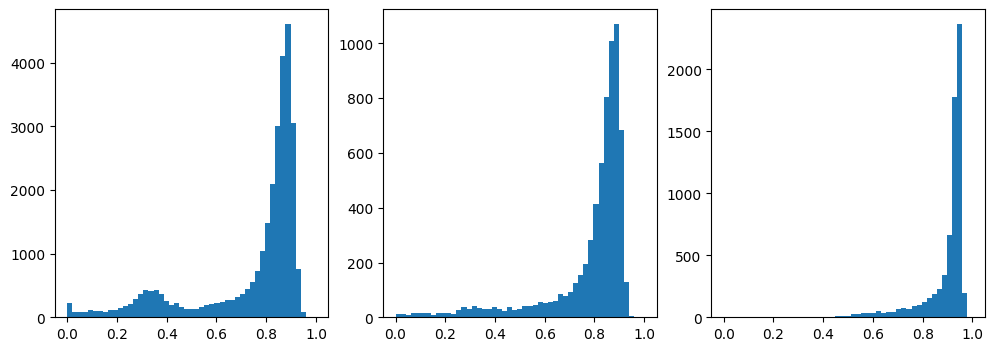

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].hist(r2, bins=np.linspace(0, 1, 50))


axs[1].hist(r2_test, bins=np.linspace(0, 1, 50))

axs[2].hist(correlation_results["correlation_with_bulk"], bins=np.linspace(0, 1, 50))

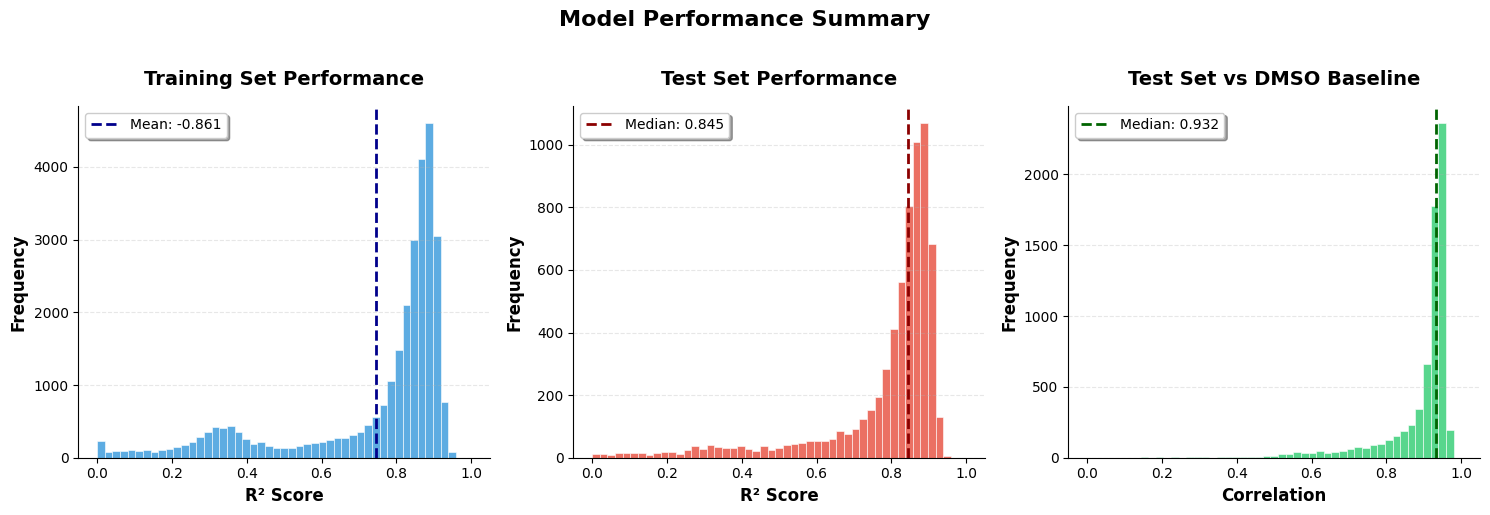


                    PERFORMANCE SUMMARY
Metric                         Median          Std            
----------------------------------------------------------------------
Training R²                    0.8241          5.5617         
Test R²                        0.8452          1.1660         
Test vs Bulk Correlation       0.9316          0.0991         


In [ ]:
# Create a prettier version of the 3-panel histogram
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Set a nice color palette
colors = ["#3498db", "#e74c3c", "#2ecc71"]

# Plot 1: Training R2
axs[0].hist(
    r2,
    bins=np.linspace(0, 1, 50),
    color=colors[0],
    edgecolor="white",
    linewidth=0.5,
    alpha=0.8,
)
axs[0].set_xlabel("R² Score", fontsize=12, fontweight="bold")
axs[0].set_ylabel("Frequency", fontsize=12, fontweight="bold")
axs[0].set_title("Training Set Performance", fontsize=14, fontweight="bold", pad=15)
axs[0].axvline(
    np.mean(r2[r2 > 0]),
    color="darkblue",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {np.mean(r2):.3f}",
)
axs[0].legend(fontsize=10, frameon=True, shadow=True)
axs[0].grid(axis="y", alpha=0.3, linestyle="--")
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)

# Plot 2: Test R2
axs[1].hist(
    r2_test,
    bins=np.linspace(0, 1, 50),
    color=colors[1],
    edgecolor="white",
    linewidth=0.5,
    alpha=0.8,
)
axs[1].set_xlabel("R² Score", fontsize=12, fontweight="bold")
axs[1].set_ylabel("Frequency", fontsize=12, fontweight="bold")
axs[1].set_title("Test Set Performance", fontsize=14, fontweight="bold", pad=15)
axs[1].axvline(
    np.median(r2_test),
    color="darkred",
    linestyle="--",
    linewidth=2,
    label=f"Median: {np.median(r2_test):.3f}",
)
axs[1].legend(fontsize=10, frameon=True, shadow=True)
axs[1].grid(axis="y", alpha=0.3, linestyle="--")
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)

# Plot 3: Correlation with Bulk
axs[2].hist(
    correlation_results["correlation_with_bulk"],
    bins=np.linspace(0, 1, 50),
    color=colors[2],
    edgecolor="white",
    linewidth=0.5,
    alpha=0.8,
)
axs[2].set_xlabel("Correlation", fontsize=12, fontweight="bold")
axs[2].set_ylabel("Frequency", fontsize=12, fontweight="bold")
axs[2].set_title("Test Set vs DMSO Baseline", fontsize=14, fontweight="bold", pad=15)
axs[2].axvline(
    np.median(correlation_results["correlation_with_bulk"]),
    color="darkgreen",
    linestyle="--",
    linewidth=2,
    label=f"Median: {np.median(correlation_results['correlation_with_bulk']):.3f}",
)
axs[2].legend(fontsize=10, frameon=True, shadow=True)
axs[2].grid(axis="y", alpha=0.3, linestyle="--")
axs[2].spines["top"].set_visible(False)
axs[2].spines["right"].set_visible(False)

# Overall title
fig.suptitle("Model Performance Summary", fontsize=16, fontweight="bold", y=1.02)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "=" * 70)
print(" " * 20 + "PERFORMANCE SUMMARY")
print("=" * 70)
print(f"{'Metric':<30} {'Median':<15} {'Std':<15}")
print("-" * 70)
print(f"{'Training R²':<30} {np.median(r2):<15.4f} {np.std(r2):<15.4f}")
print(f"{'Test R²':<30} {np.median(r2_test):<15.4f} {np.std(r2_test):<15.4f}")
print(
    f"{'Test vs Bulk Correlation':<30} {np.median(correlation_results['correlation_with_bulk']):<15.4f} {np.std(correlation_results['correlation_with_bulk']):<15.4f}"
)
print("=" * 70)

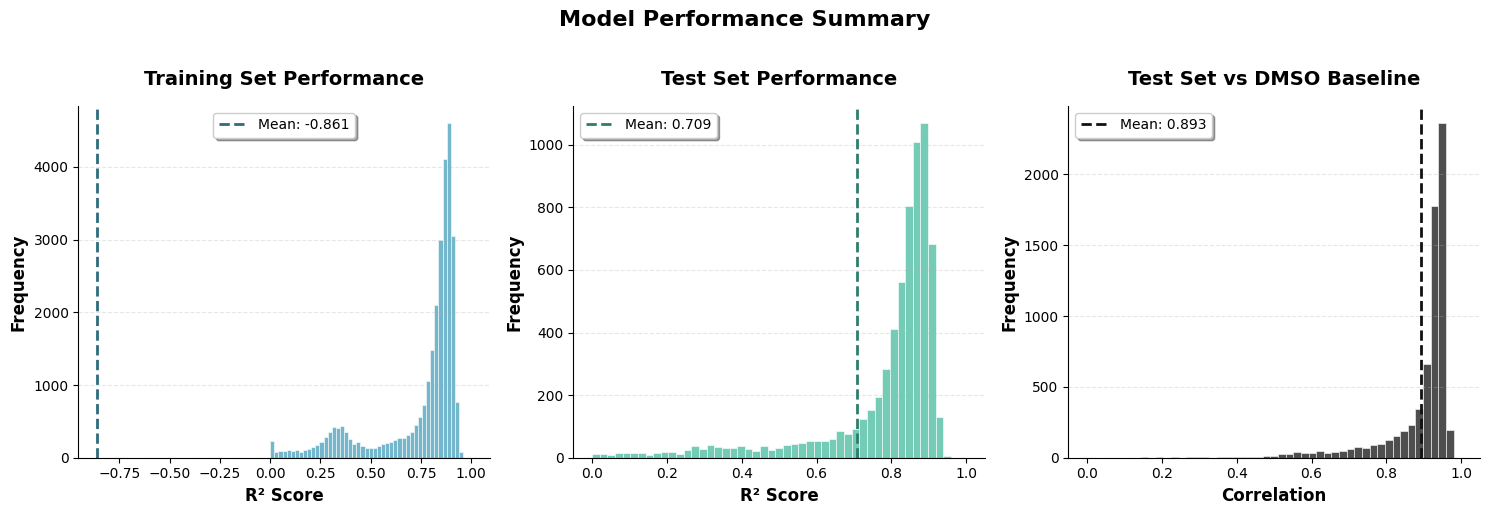


                    PERFORMANCE SUMMARY
Metric                         Mean            Std            
----------------------------------------------------------------------
Training R²                    -0.8609         5.5617         
Test R²                        0.7089          1.1660         
Test vs Bulk Correlation       0.8933          0.0991         


In [ ]:
# Create a prettier version with custom color scheme
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Custom color palette
colors = ["#51A4C0", "#51C0A5", "#222222"]

# Plot 1: Training R2
axs[0].hist(
    r2,
    bins=np.linspace(0, 1, 50),
    color=colors[0],
    edgecolor="white",
    linewidth=0.5,
    alpha=0.8,
)
axs[0].set_xlabel("R² Score", fontsize=12, fontweight="bold")
axs[0].set_ylabel("Frequency", fontsize=12, fontweight="bold")
axs[0].set_title("Training Set Performance", fontsize=14, fontweight="bold", pad=15)
axs[0].axvline(
    np.mean(r2),
    color="#2d6b7d",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {np.mean(r2):.3f}",
)
axs[0].legend(fontsize=10, frameon=True, shadow=True)
axs[0].grid(axis="y", alpha=0.3, linestyle="--")
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)

# Plot 2: Test R2
axs[1].hist(
    r2_test,
    bins=np.linspace(0, 1, 50),
    color=colors[1],
    edgecolor="white",
    linewidth=0.5,
    alpha=0.8,
)
axs[1].set_xlabel("R² Score", fontsize=12, fontweight="bold")
axs[1].set_ylabel("Frequency", fontsize=12, fontweight="bold")
axs[1].set_title("Test Set Performance", fontsize=14, fontweight="bold", pad=15)
axs[1].axvline(
    np.mean(r2_test),
    color="#2d7d6b",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {np.mean(r2_test):.3f}",
)
axs[1].legend(fontsize=10, frameon=True, shadow=True)
axs[1].grid(axis="y", alpha=0.3, linestyle="--")
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)

# Plot 3: Correlation with Bulk
axs[2].hist(
    correlation_results["correlation_with_bulk"],
    bins=np.linspace(0, 1, 50),
    color=colors[2],
    edgecolor="white",
    linewidth=0.5,
    alpha=0.8,
)
axs[2].set_xlabel("Correlation", fontsize=12, fontweight="bold")
axs[2].set_ylabel("Frequency", fontsize=12, fontweight="bold")
axs[2].set_title("Test Set vs DMSO Baseline", fontsize=14, fontweight="bold", pad=15)
axs[2].axvline(
    np.mean(correlation_results["correlation_with_bulk"]),
    color="#111111",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {np.mean(correlation_results['correlation_with_bulk']):.3f}",
)
axs[2].legend(fontsize=10, frameon=True, shadow=True)
axs[2].grid(axis="y", alpha=0.3, linestyle="--")
axs[2].spines["top"].set_visible(False)
axs[2].spines["right"].set_visible(False)

# Overall title
fig.suptitle("Model Performance Summary", fontsize=16, fontweight="bold", y=1.02)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "=" * 70)
print(" " * 20 + "PERFORMANCE SUMMARY")
print("=" * 70)
print(f"{'Metric':<30} {'Mean':<15} {'Std':<15}")
print("-" * 70)
print(f"{'Training R²':<30} {np.mean(r2):<15.4f} {np.std(r2):<15.4f}")
print(f"{'Test R²':<30} {np.mean(r2_test):<15.4f} {np.std(r2_test):<15.4f}")
print(
    f"{'Test vs Bulk Correlation':<30} {np.mean(correlation_results['correlation_with_bulk']):<15.4f} {np.std(correlation_results['correlation_with_bulk']):<15.4f}"
)
print("=" * 70)

In [ ]:
model

ChemPertVAE Model with the following parameters: 
n_input (drug embeddings): 768, n_output (genes): 2000, 
Training status: Trained

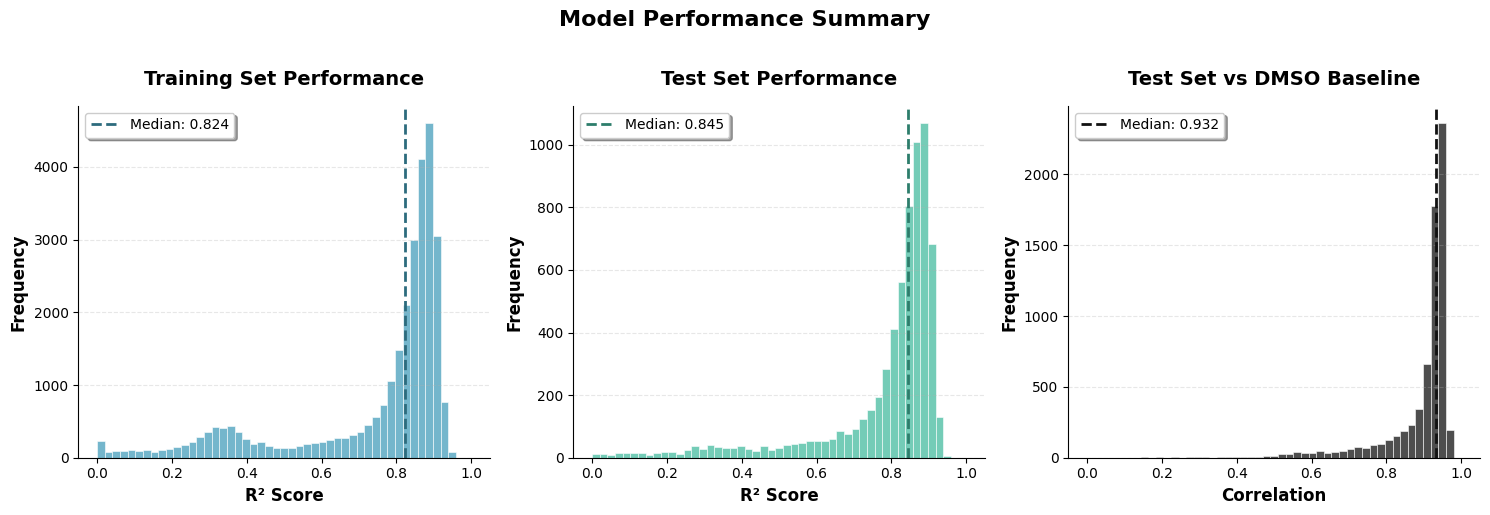


                    PERFORMANCE SUMMARY
Metric                         Median          Mean            Std            
----------------------------------------------------------------------
Training R²                    0.8241          -0.8609         5.5617         
Test R²                        0.8452          0.7089          1.1660         
Test vs Bulk Correlation       0.9316          0.8933          0.0991         


In [ ]:
# Create a prettier version with custom color scheme and median
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Custom color palette
colors = ["#51A4C0", "#51C0A5", "#222222"]

# Plot 1: Training R2
axs[0].hist(
    r2,
    bins=np.linspace(0, 1, 50),
    color=colors[0],
    edgecolor="white",
    linewidth=0.5,
    alpha=0.8,
)
axs[0].set_xlabel("R² Score", fontsize=12, fontweight="bold")
axs[0].set_ylabel("Frequency", fontsize=12, fontweight="bold")
axs[0].set_title("Training Set Performance", fontsize=14, fontweight="bold", pad=15)
axs[0].axvline(
    np.median(r2),
    color="#2d6b7d",
    linestyle="--",
    linewidth=2,
    label=f"Median: {np.median(r2):.3f}",
)
axs[0].legend(fontsize=10, frameon=True, shadow=True)
axs[0].grid(axis="y", alpha=0.3, linestyle="--")
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)

# Plot 2: Test R2
axs[1].hist(
    r2_test,
    bins=np.linspace(0, 1, 50),
    color=colors[1],
    edgecolor="white",
    linewidth=0.5,
    alpha=0.8,
)
axs[1].set_xlabel("R² Score", fontsize=12, fontweight="bold")
axs[1].set_ylabel("Frequency", fontsize=12, fontweight="bold")
axs[1].set_title("Test Set Performance", fontsize=14, fontweight="bold", pad=15)
axs[1].axvline(
    np.median(r2_test),
    color="#2d7d6b",
    linestyle="--",
    linewidth=2,
    label=f"Median: {np.median(r2_test):.3f}",
)
axs[1].legend(fontsize=10, frameon=True, shadow=True)
axs[1].grid(axis="y", alpha=0.3, linestyle="--")
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)

# Plot 3: Correlation with Bulk
axs[2].hist(
    correlation_results["correlation_with_bulk"],
    bins=np.linspace(0, 1, 50),
    color=colors[2],
    edgecolor="white",
    linewidth=0.5,
    alpha=0.8,
)
axs[2].set_xlabel("Correlation", fontsize=12, fontweight="bold")
axs[2].set_ylabel("Frequency", fontsize=12, fontweight="bold")
axs[2].set_title("Test Set vs DMSO Baseline", fontsize=14, fontweight="bold", pad=15)
axs[2].axvline(
    np.median(correlation_results["correlation_with_bulk"]),
    color="#111111",
    linestyle="--",
    linewidth=2,
    label=f"Median: {np.median(correlation_results['correlation_with_bulk']):.3f}",
)
axs[2].legend(fontsize=10, frameon=True, shadow=True)
axs[2].grid(axis="y", alpha=0.3, linestyle="--")
axs[2].spines["top"].set_visible(False)
axs[2].spines["right"].set_visible(False)

# Overall title
fig.suptitle("Model Performance Summary", fontsize=16, fontweight="bold", y=1.02)

plt.tight_layout()
plt.show()

# Print summary statistics with median
print("\n" + "=" * 70)
print(" " * 20 + "PERFORMANCE SUMMARY")
print("=" * 70)
print(f"{'Metric':<30} {'Median':<15} {'Mean':<15} {'Std':<15}")
print("-" * 70)
print(
    f"{'Training R²':<30} {np.median(r2):<15.4f} {np.mean(r2):<15.4f} {np.std(r2):<15.4f}"
)
print(
    f"{'Test R²':<30} {np.median(r2_test):<15.4f} {np.mean(r2_test):<15.4f} {np.std(r2_test):<15.4f}"
)
print(
    f"{'Test vs Bulk Correlation':<30} {np.median(correlation_results['correlation_with_bulk']):<15.4f} {np.mean(correlation_results['correlation_with_bulk']):<15.4f} {np.std(correlation_results['correlation_with_bulk']):<15.4f}"
)
print("=" * 70)

### distribution

In [ ]:
import numpy as np

x = np.linspace(-3, 3, 100)

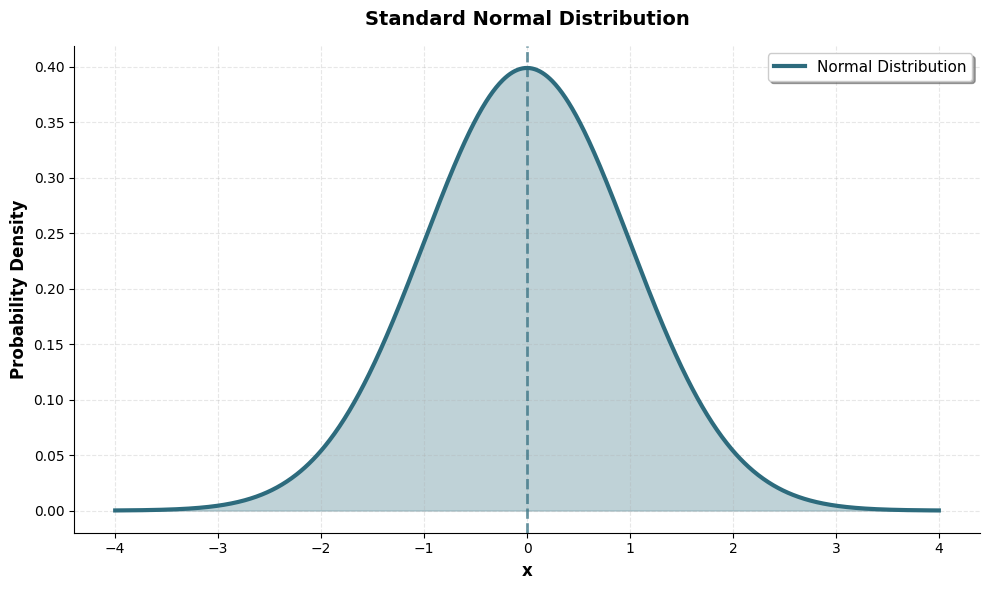

Mean: 0
Standard Deviation: 1
68% of data falls within 1 standard deviation: [-1.0, 1.0]
95% of data falls within 2 standard deviations: [-2.0, 2.0]
99.7% of data falls within 3 standard deviations: [-3.0, 3.0]


In [ ]:
# Plot a normal distribution
from scipy.stats import norm

# Generate x values
x = np.linspace(-4, 4, 1000)
# Standard normal distribution (mean=0, std=1)
y = norm.pdf(x, 0, 1)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the normal distribution
ax.plot(x, y, color="#2d6b7d", linewidth=3, label="Normal Distribution")
ax.fill_between(x, y, alpha=0.3, color="#2d6b7d")

# Styling
ax.set_xlabel("x", fontsize=12, fontweight="bold")
ax.set_ylabel("Probability Density", fontsize=12, fontweight="bold")
ax.set_title("Standard Normal Distribution", fontsize=14, fontweight="bold", pad=15)
ax.legend(fontsize=11, frameon=True, shadow=True)
ax.grid(alpha=0.3, linestyle="--")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Add vertical line at mean
ax.axvline(0, color="#2d6b7d", linestyle="--", linewidth=2, alpha=0.7, label="Mean = 0")

plt.tight_layout()
plt.show()

print("Mean: 0")
print("Standard Deviation: 1")
print(f"68% of data falls within 1 standard deviation: [{-1:.1f}, {1:.1f}]")
print(f"95% of data falls within 2 standard deviations: [{-2:.1f}, {2:.1f}]")
print(f"99.7% of data falls within 3 standard deviations: [{-3:.1f}, {3:.1f}]")

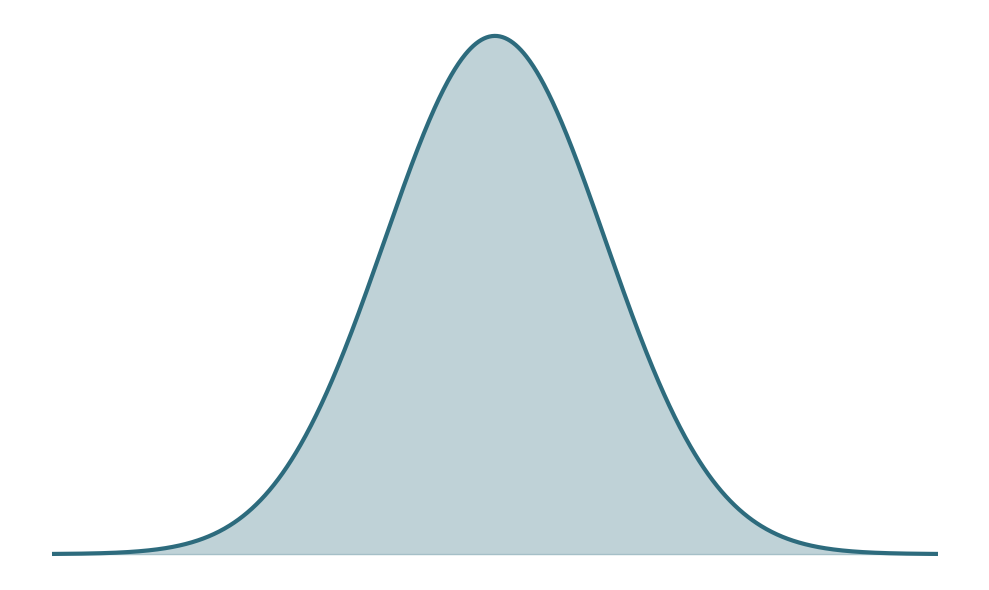

In [ ]:
# Plot a clean normal distribution without labels
from scipy.stats import norm

# Generate x values
x = np.linspace(-4, 4, 1000)
# Standard normal distribution (mean=0, std=1)
y = norm.pdf(x, 0, 1)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the normal distribution
ax.plot(x, y, color="#2d6b7d", linewidth=3)
ax.fill_between(x, y, alpha=0.3, color="#2d6b7d")

# Remove all labels, ticks, and spines
ax.set_xticks([])
ax.set_yticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

plt.tight_layout()
plt.savefig("/Users/lucas-diedrich/Downloads/gaussian.svg", bbox_inches="tight")

In [ ]:
calibration = np.linspace(0.01, 0.99, 20)
calibration_results = {}
for c in calibration:
    calibration_results[c] = model.get_ci_calibration(confidence_level=c)

In [ ]:
calibration_results = pd.DataFrame(calibration_results).T
calibration_results

,expected_coverage,observed_coverage,coverage_per_sample,calibration_error
0.010000,0.010000,0.011394,0.011394,0.001394
0.061579,0.061579,0.073296,0.073296,0.011717
0.113158,0.113158,0.151656,0.151656,0.038498
0.164737,0.164737,0.247772,0.247772,0.083035
0.216316,0.216316,0.342353,0.342353,0.126037
0.267895,0.267895,0.422344,0.422344,0.154449
0.319474,0.319474,0.487048,0.487048,0.167575
0.371053,0.371053,0.545026,0.545026,0.173974
0.422632,0.422632,0.595733,0.595733,0.173101
0.474211,0.474211,0.643570,0.643570,0.169359


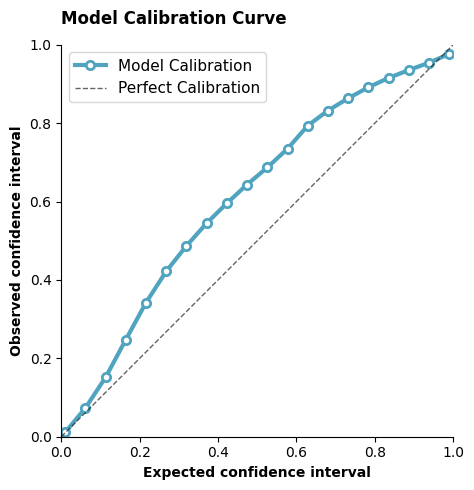

In [ ]:
# Create a prettier calibration plot with diagonal reference line
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the actual calibration curve
ax.plot(
    calibration_results["expected_coverage"],
    calibration_results["observed_coverage"],
    color="#51A4C0",
    linewidth=3,
    marker="o",
    markersize=6,
    markerfacecolor="white",
    markeredgewidth=2,
    markeredgecolor="#51A4C0",
    label="Model Calibration",
)

# Add diagonal line for perfect calibration
ax.plot(
    [0, 1],
    [0, 1],
    color="#222222",
    linestyle="--",
    linewidth=1,
    alpha=0.7,
    label="Perfect Calibration",
)

# Styling
ax.set_xlabel("Expected confidence interval", fontsize=10, fontweight="bold")
ax.set_ylabel("Observed confidence interval", fontsize=10, fontweight="bold")
ax.set_title(
    "Model Calibration Curve", fontsize=12, fontweight="bold", pad=15, loc="left"
)
ax.legend(fontsize=11, frameon=True, shadow=False, loc="upper left")
# ax.grid(alpha=0.3, linestyle='--')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set equal aspect ratio for square plot
ax.set_aspect("equal")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()